# Federal Reserve Minutes Sentiment Analysis 

The objective of this notebook is to extract topics and sentiment from Federal Minutes (2004-Present), leveraging natural language techniques such as bag of words and Latent Dirichlet Allocation (LDA). Sentiment is calculated using FinBert

Please use NBviewer for rendering if plotly graphs do not appear (via http://nbviewer.jupyter.org/github/JonnyFLDN/Federal-Reserve-Minutes-Topic-and-Sentiment-Modelling/blob/master/Topic%20%26%20Sentiment%20Analysis.ipynb)

# <a name="meth-out"></a>Method Outline:

## <a name="p-flow"></a>Process Flow

# <a name="data-o"></a> Data Overview
Data was web scrapped using [Webscraper.py](https://github.com/JonnyFLDN/Federal-Reserve-Minutes-Topic-and-Sentiment-Modelling/blob/master/Minutes_Webscraper.py) from https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm and saved in the directory below. 
The year 2004 was chosen as the start-year given the acceleration of release dates to 3 weeks, and improved clarity in explanations of committee’s decisions and views [(Danker,2005)](https://www.federalreserve.gov/pubs/bulletin/2005/spring05_fomc.pdf)

<br> 
In this section we will examine the transcripts' structure.

## <a name="sum"></a>Summary

In [1]:
import os
import pandas as pd
import numpy as np 
import re
import string

from utils.corpusutils import CorpusPreProcess, Document, Corpus
from utils.featureutils import FeatureProcessor,find_closest


from nltk.tokenize import WordPunctTokenizer
from nltk.data import LazyLoader
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon
import torch
import joblib
import pickle
import pyLDAvis
import pyLDAvis.sklearn as sklearnvis
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings('ignore')

In [2]:

current_directory = os.getcwd()
root = os.path.join(current_directory,"Minutes")
word_tokenizer = WordPunctTokenizer()
sent_tokenizer = LazyLoader("tokenizers/punkt/english.pickle")
category_pattern = r'(\d{4})/*'
file_extension = r'*.txt'
file_pattern = r'(\d{8})/*'
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english') + list(string.punctuation) + ['u','.','s','--','-','."',',"','.)',')-','".','—','),'] 


fed_mins = CorpusPreProcess(root=root,file_extension = file_extension,
                            category_pattern=category_pattern,
                            file_pattern=file_pattern,
                            word_tokenizer = word_tokenizer,
                            sent_tokenizer=sent_tokenizer,
                            stemmer = stemmer,
                            lemmatizer = lemmatizer,
                            stop_words = stop_words
                            )

In [3]:
fed_mins_ids = fed_mins.get_file_ids()

print('Total number of files: '+str(len(fed_mins_ids)))
print('Number of paragraphs: '+str(len(fed_mins.get_paras())))
print('Number of sentences: '+str(len(fed_mins.get_sents())))
print('Number of words: '+str(len(fed_mins.get_words())))
print('\n'+'First file: '+ fed_mins_ids[0])
print('Last file: '+ fed_mins_ids[-1])

Total number of files: 143
Number of paragraphs: 17241
Number of sentences: 45009
Number of words: 1238889

First file: 20040128
Last file: 20211215


In [4]:
#For each Category
para_by_year = {}

for cat in fed_mins.get_category_ids():
    files = fed_mins.get_file_ids(category_id=cat)
    para_by_year[cat] = {'nparas':sum(len(fed_mins.get_paras(file_id=f)) for f in files)/len(files),
                        'nwords':sum(len(fed_mins.get_words(file_id=f)) for f in files)/len(files)}


<AxesSubplot:title={'center':'Paragraphs and words overtime'}>

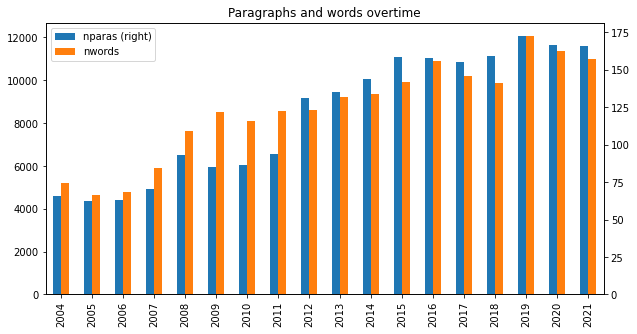

In [5]:
pd.DataFrame.from_dict(para_by_year).T.sort_index().plot(kind='bar',secondary_y='nparas',figsize=(10,5),title='Paragraphs and words overtime')


We can see an acceleration in the amount of paragraphs and words overtime.

In [6]:
start_regex = r"""(?i)(staff\sreview\sof\sthe\seconomic|the\sinformation\s[\s]?(?:reviewed|received|provided)|the\scommittee\sthen\sturned\sto\sa\sdiscussion\sof\sthe\seconomic\soutlook|in\sthe\scommittee[\']?s\sdiscussion\sof\scurrent\sand\sprospective\seconomic)"""
end_regex = r"""(?i)(at\sthe\sconclusion\sof\s[\s]?(?:the|this)\s(?:discussion|meetings)|the\scommitte\svoted\sto\sauthorize|the\svote\sencompassed\sapproval\sof)"""
file_stats = fed_mins.truncate_text(start_regex,end_regex,return_stats=True)

Overwritting existing folder


In [7]:
pd.Series(file_stats).rename('size_pct_change').to_frame().sort_values(by='size_pct_change')

,size_pct_change
20200129.txt,-60.414296
20190130.txt,-59.268669
20180131.txt,-58.432987
20140129.txt,-57.307791
20050202.txt,-56.184258
...,...
20060629.txt,-14.868293
20060328.txt,-14.413643
20051101.txt,-14.146784
20061212.txt,-13.915782


At most files reduced by 60%

# Further pre-processing

In [8]:
file_example = '20171213'
sent_example = fed_mins.get_sents(file_id=file_example,stem=True,lemmatize=True)[32]
print('\033[1m'+"Example Sentence"+'\033[0m')
print(TreebankWordDetokenizer().detokenize(sent_example))

print('\n'+'\033[1m'+"Tokenize"+'\033[0m')
print(sent_example)

print('\n'+'\033[1m'+"Stem tokens"+'\033[0m')
sent_stemmed = sent_example.stem
print(sent_stemmed)

print('\n'+'\033[1m'+"Lemmatize tokens"+'\033[0m')
sent_lemmatized = sent_example.lemma
print(sent_lemmatized)

Example Sentence
Total U . S . consumer prices, as measured by the PCE price index, increased slightly more than 1 - 1 / 2 percent over the 12 months ending in October.

Tokenize
['Total', 'U', '.', 'S', '.', 'consumer', 'prices', ',', 'as', 'measured', 'by', 'the', 'PCE', 'price', 'index', ',', 'increased', 'slightly', 'more', 'than', '1', '-', '1', '/', '2', 'percent', 'over', 'the', '12', 'months', 'ending', 'in', 'October', '.']

Stem tokens
['total', 'consum', 'price', 'measur', 'pce', 'price', 'index', 'increas', 'slightli', 'percent', 'month', 'end', 'octob']

Lemmatize tokens
['total', 'consumer', 'price', 'measure', 'pce', 'price', 'index', 'increase', 'slightly', 'percent', 'month', 'end', 'october']


# LDA

In [9]:
paras = fed_mins.get_paras(flatten=True,stem=True)
def return_self(x):return x

#we can use lemmatization in tokenizer
#but tokenizer is done before stop word removal

vectorizer = CountVectorizer(tokenizer=return_self,lowercase=False,preprocessor=return_self)
bag_of_words = vectorizer.fit_transform((doc.stem for doc in paras))

num_topics = 6

lda_model = LatentDirichletAllocation(n_components = num_topics,
                                    max_iter = 20,
                                    #doc_topic_prior = 0.5,
                                    learning_method = 'online',
                                    random_state =10,
                                    n_jobs=-1)

lda_transform = lda_model.fit_transform(bag_of_words)

def summarize_topics(model, feature_names, no_top_words):
    topics = pd.DataFrame()
    
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i]for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics["Topic %d:" % (topic_idx)] = top_words
    
    return topics


In [10]:
## What are the most frequently used words
term_counts = {i:j for i,j in zip(vectorizer.get_feature_names(),bag_of_words.toarray().sum(axis=0))}
df_term_counts = pd.DataFrame(sorted(term_counts.items(),key=lambda x:x[1],reverse=True),columns=['term','count'])
df_term_counts.head(5)

,term,count
0,inflat,6301
1,rate,5672
2,particip,5530
3,market,4969
4,price,4854


We could improve our modelling by eliminating frequent words that don't add much to a topic. 

In [11]:
df_results = summarize_topics(lda_model,vectorizer.get_feature_names(),10)
df_results


,Topic 0:,Topic 1:,Topic 2:,Topic 3:,Topic 4:,Topic 5:
0,particip,quarter,market,particip,loan,inflat
1,polici,increas,fund,labor,yield,price
2,inflat,spend,financi,rate,remain,expect
3,econom,product,secur,busi,credit,year
4,committe,real,rate,continu,period,consum
5,would,busi,treasuri,sector,market,measur
6,rate,declin,period,employ,bank,staff
7,risk,good,asset,market,declin,percent
8,expect,manufactur,term,recent,bond,energi
9,feder,sale,feder,hous,intermeet,month


In [12]:
#Dictionary with topivs
topic_dict = {0 : 'Outlook',
              1 : 'Aggregate Demand',
              2 : 'Financial Market', 
              3 : 'Labour', 
              4 : 'Credit Market',
              5 : 'Inflation'}


In [13]:
sklearnvis.prepare(lda_model,bag_of_words,vectorizer)

/Users/jonny/anaconda/envs/orbenv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jonny/anaconda/envs/orbenv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jonny/anaconda/envs/orbenv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jonny/anaconda/envs/orbenv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.026697 -0.249434       1        1  27.548472
5      0.121069 -0.019016       2        1  18.968352
3      0.086028 -0.092860       3        1  17.691395
4     -0.021287  0.107802       4        1  17.151958
1      0.157253  0.181850       5        1  11.880203
2     -0.316365  0.071658       6        1   6.759620, topic_info=          Term         Freq        Total Category  logprob  loglift
1559    inflat  6270.000000  6270.000000  Default  30.0000  30.0000
2208  particip  5615.000000  5615.000000  Default  29.0000  29.0000
2453   quarter  3355.000000  3355.000000  Default  28.0000  28.0000
1839    market  4919.000000  4919.000000  Default  27.0000  27.0000
1312      fund  1887.000000  1887.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
290       back   215.919989   631.038439   Topic6  -4.9139   1.6217
604     condit   252.372251  2657.041737   Topic6  -4.7579   0.3401
1740     level   225.724375  2292.672083   Topic6  -4.8695   0.3760
1537   increas   202.327275  4182.649830   Topic6  -4.9790  -0.3346
2596    remain   191.858678  3746.773235   Topic6  -5.0321  -0.2777

[433 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5         4  0.983004        ).
64        1  0.724647  accommod
64        2  0.012765  accommod
64        4  0.262169  accommod
73        1  0.994373    achiev
...     ...       ...       ...
3576      1  0.014466     yield
3576      4  0.984532     yield
3594      2  0.993818         ‑
3597      2  0.924095         –
3597      6  0.054359         –

[825 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 4, 5, 2, 3])

# Topic proportions overtime

In [14]:
categories = pd.Series([p.category_id for p in paras])


In [15]:
count = 0
year_prop = {}
for idx,year in categories[~(categories==categories.shift(-1))].iteritems():
    c = lda_transform[count:count+int(idx)]
    year_prop[int(year)] = 100*(c.sum(axis=0)/c.sum())
    count = idx



<AxesSubplot:>

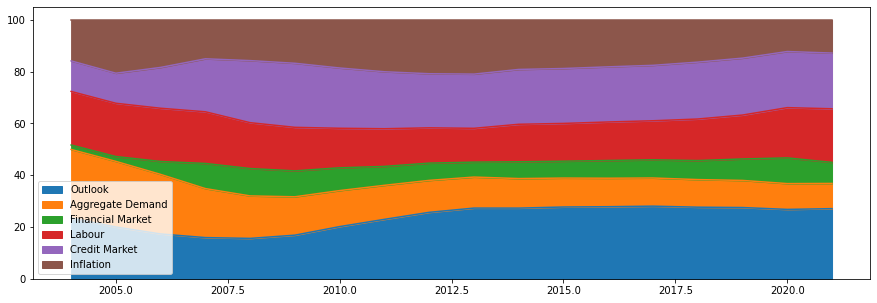

In [16]:
yearly_prop = pd.DataFrame(year_prop).T.sort_index()
yearly_prop.columns = yearly_prop.columns.map(topic_dict)
yearly_prop.plot(kind='area',stacked=True,figsize=(15,5))


## <a name="finbert"></a>FinBERT
FinBERT is a pre-trained transformer model, specifically trained for the finance domain. https://github.com/ProsusAI/finBERT. The sentiment scoring component derives from Financial PhraseBank dataset. 
Here we will score each old text instead of our lemmatised 'new text'. 

In [17]:
#Load tokenizer and model
transformer_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
transformer_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",output_hidden_states=True,output_attentions=False)
 

In [18]:
text = ['Participants','remarked','that','inflation','readings','had','been','higher','and','were','more','persistent','and','widespread','than','previously','anticipated','.']

In [19]:
print(transformer_tokenizer.convert_ids_to_tokens(transformer_tokenizer(paras[0].tokens,padding=True,is_split_into_words=True)['input_ids']))

['[CLS]', 'and', 'the', 'conduct', 'of', 'monetary', 'policy', 'over', 'the', 'inter', '##me', '##eti', '##ng', 'period', '.', '[SEP]']


In [20]:
#How many our of documents get truncated?
plengths = []
for p in paras:
    plengths.append(len(transformer_tokenizer.encode(p.tokens,padding=True,is_split_into_words=True)))

Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors


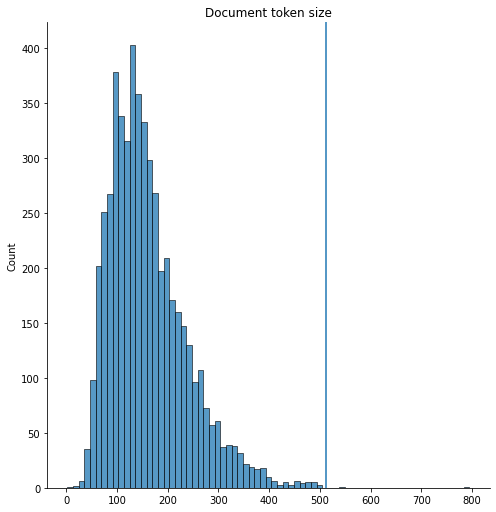

In [21]:

sns.displot(plengths,height=7).set(title='Document token size')
plt.axvline(transformer_tokenizer.model_max_length)

Most documents have tokens less than the maximum model size, which means we don't have to worry about truncation, in fact we could probably truncate our tokens to 350

## Extracting features from latest transcript

In [22]:
file_id = '20211215'
latest_minutes = fed_mins.get_paras(file_id = file_id,flatten=True,stem=True)
tokenizer_settings = dict(is_split_into_words=True,max_length=350,padding='max_length',truncation=True,return_tensors="pt")

document_feat = FeatureProcessor(latest_minutes,
                                transformer_model=transformer_model,
                                transformer_tokenizer=transformer_tokenizer,
                                tokenizer_settings=tokenizer_settings,
                                lda_model=lda_model,
                                lda_vec=vectorizer,
                                lda_topic_dict=topic_dict,batch_size=30)

In [23]:
latest_minutes = document_feat.get_features(sentiment=True,embedding=True,topic=True)


In [24]:
def corpus_stats(corpus):
    ids = [(n,f.category_id,f.file_id) for n,f in enumerate(corpus)]
    df_ids = pd.DataFrame(ids,columns=['idx','category_id','file_id'])
    start_idx = df_ids.drop_duplicates(['category_id','file_id'],keep='first')
    end_idx = df_ids.drop_duplicates(['category_id','file_id'],keep='last')

    idx = start_idx.merge(end_idx,on=['category_id','file_id'],suffixes=('_start','_end'))

    stats =[]
    corpus_sent = corpus.extract_features('sentiment')
    corpus_topic = corpus.extract_features('topics')

    for s,cat_id,file_id,e in idx.values:
        net_tone = [s['logits'][0] - s['logits'][1] for s in corpus_sent[s:e]]
        topic_dist = [s['topic_dist'] for s in corpus_topic[s:e]]
        topic_sentiment = np.asarray(topic_dist) * np.asarray(net_tone).reshape(-1,1)
        topic_mean_sent = topic_sentiment.mean(axis=0).tolist()

        stats.append((cat_id,file_id,*topic_mean_sent))
    return stats


latest_stats = corpus_stats(latest_minutes)
latest_stats = pd.DataFrame(latest_stats,columns = ['category_id','file_id']+list(topic_dict.values()))
latest_stats['month'] = pd.to_datetime(latest_stats['file_id']).dt.to_period('M')
latest_stats.set_index(['month'],inplace=True)

<AxesSubplot:title={'center':'Average net-tone per topic for file:20211215'}, xlabel='month'>

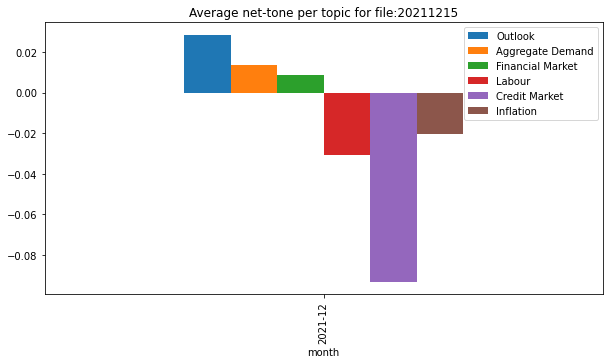

In [25]:
latest_stats.plot(kind='bar',title='Average net-tone per topic for file:{}'.format(file_id),figsize=(10,5))

without context from previous transcript, this doesn't tell us much 

In [26]:
last_year_minutes = fed_mins.get_paras(category_id = '2021',flatten=True,stem=True)

document_feat = FeatureProcessor(last_year_minutes,
                                transformer_model=transformer_model,
                                transformer_tokenizer=transformer_tokenizer,
                                tokenizer_settings=tokenizer_settings,
                                lda_model=lda_model,
                                lda_vec=vectorizer,
                                lda_topic_dict=topic_dict,batch_size=30)

In [27]:
last_year_minutes = document_feat.get_features()

In [28]:
last_year_stats = pd.DataFrame(corpus_stats(last_year_minutes),columns = ['category_id','file_id']+list(topic_dict.values()))

last_year_stats['month'] = pd.to_datetime(last_year_stats['file_id']).dt.to_period('M')
last_year_stats.set_index(['month'],inplace=True)

<AxesSubplot:title={'center':'Topic Sentiment across time'}, xlabel='month'>

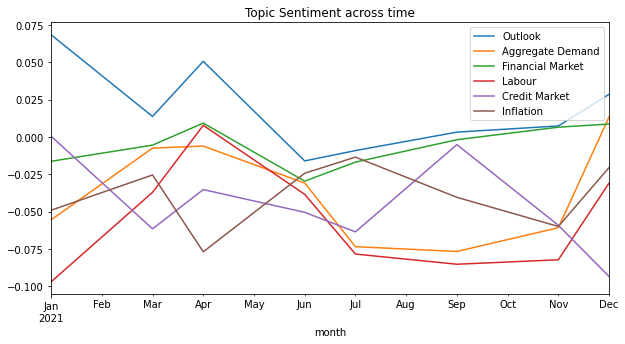

In [29]:
last_year_stats[[i for i in last_year_stats.columns if i not in ['category_id','file_id']]].plot(kind='line',figsize=(10,5),title='Topic Sentiment across time')

<AxesSubplot:title={'center':'latest transcript relative to past year'}, xlabel='month'>

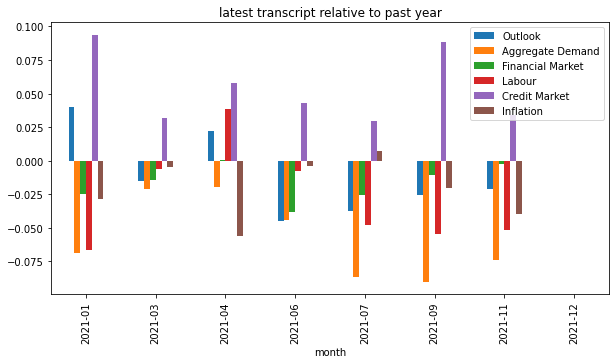

In [30]:
relative_stats = pd.DataFrame(last_year_stats[topic_dict.values()].values - latest_stats[topic_dict.values()].values,columns=topic_dict.values(),index=last_year_stats.index)
relative_stats.plot(kind='bar',title='latest transcript relative to past year',figsize=(10,5))

## What is the relationship between document embeddings and topic distribution? 
Here we plot cosine simlarity of document embeddings vs KL- divergence

In [31]:
doc_embeddings = np.asarray(last_year_minutes.extract_features('embedding'))

In [32]:
cos = cosine_similarity(doc_embeddings,doc_embeddings)
cos_flat = cos[np.triu_indices(cos.shape[0],1)]

In [33]:
topic_dist = [i['topic_dist'] for i in last_year_minutes.extract_features('topics')]

tri = np.triu_indices(cos.shape[0],1)
jen_lst = []
for i,j in zip(tri[0],tri[1]):
    jen_lst.append(1-jensenshannon(topic_dist[i],topic_dist[j]))


Jensen shannon allows us to compute a distance metric based on probability distributions

In [34]:
df_embed_vs_topic = pd.DataFrame([cos_flat,jen_lst]).T
df_embed_vs_topic.columns = ['embed_cosine_similarity','topic_jensenshannon_dist']


In [35]:
df_embed_vs_topic.describe()

,embed_cosine_similarity,topic_jensenshannon_dist
count,67161.000000,67161.000000
mean,0.778039,0.400860
std,0.085215,0.189431
min,0.206556,0.189638
25%,0.730725,0.237379
50%,0.787025,0.343117
75%,0.836475,0.515285
max,1.000000,1.000000


Text(0.5, 1.0, 'Document embedding cosine similarity vs Topic (1- Jensen shannon distance) ')

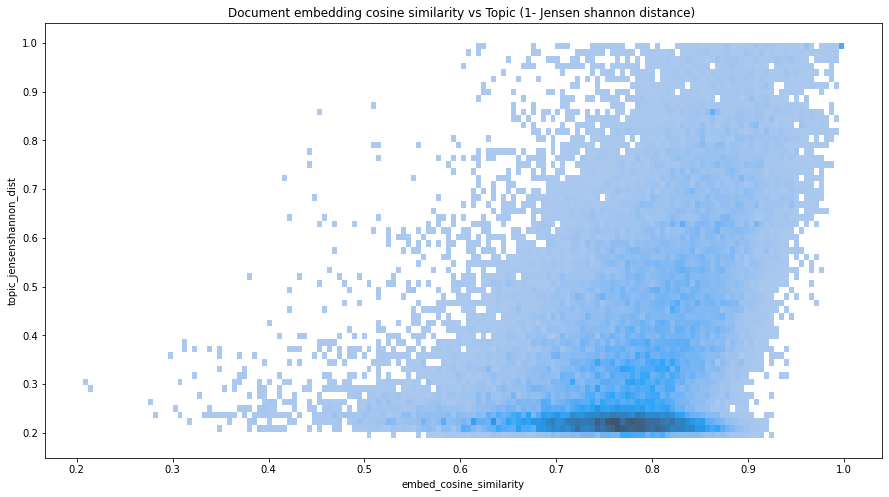

In [36]:
plt.figure(figsize=(15,8))
ax = sns.histplot(df_embed_vs_topic,x='embed_cosine_similarity',y='topic_jensenshannon_dist')
plt.title('Document embedding cosine similarity vs Topic (1- Jensen shannon distance) ')

When embed_cosine_similarity = 1, we have documents that are very closely related. Likewise when topic (1-Jensen shannon distance) = 1, topic distributiions are indentical. A large proportion of closely related documents (as indicated by cosine) have not so closely related topic distributions.

In [37]:
df_embed_vs_topic.corr()

,embed_cosine_similarity,topic_jensenshannon_dist
embed_cosine_similarity,1.000000,0.457876
topic_jensenshannon_dist,0.457876,1.000000


# Comparing against other corpus
Here we try to find documents similar to corpus_a and compare topic distribution/sentiment. Our example comes from FOMC commitee member Jerome Powell

In [38]:

base_text = "Inflation risks are still to the upside in the views of most FOMC participants, and certainly in my view as well. There’s a risk that the high inflation we are seeing will be prolonged. There’s a risk that it will move even higher. So, we don’t think that’s the base case, but, you asked what the risks are, and we have to be in a position with our monetary policy to address all of the plausible outcomes"
base_text_2 = "US labour costs have risen sharply, contributing to the rapid climb of inflation as the Federal Reserve prepares to act forcefully to temper demand in the world's largest economy"


#convert text into CorpusPreProcess format
base_document = [('2022','20220128',base_text),('2022','2022029',base_text_2)]


In [39]:

base_corpus = CorpusPreProcess(root=base_document,file_extension = file_extension,
                            category_pattern=category_pattern,
                            file_pattern=file_pattern,
                            word_tokenizer = word_tokenizer,
                            sent_tokenizer=sent_tokenizer,
                            stemmer = stemmer,
                            lemmatizer = lemmatizer,
                            stop_words = stop_words
                            )

base_document = base_corpus.get_paras(flatten=True,stem=True)

In [40]:
base_features = FeatureProcessor(base_document,
                                transformer_model=transformer_model,
                                transformer_tokenizer=transformer_tokenizer,
                                tokenizer_settings=tokenizer_settings,
                                lda_model=lda_model,
                                lda_vec=vectorizer,
                                lda_topic_dict=topic_dict,batch_size=30)

In [41]:
base_document = base_features.get_features()

In [42]:
base_document[0].features['topics']

{'topic_dist': [0.8383592633875829,
  0.00842358915194112,
  0.008435876674884159,
  0.12792577034731528,
  0.008403857954972864,
  0.008451642483303776],
 'topic_pred': 'Outlook'}

# Calculating Cosine Similarity against corpus

In [43]:

base_closest =  find_closest(base_document,last_year_minutes)

    

In [44]:
base_closest[0]

,raw_text,embed_cos_sim,topic_1-jensen_dist,net_tone,category_id,file_id,net_tone_diff,combined_score
0,Situation\nThe COVID‑19 pandemic and the meas...,0.72314,0.301999,-0.940681,2021,20210127,-0.317461,0.218388
1,Total nonfarm payroll employment fell in Decem...,0.594657,0.317956,-0.957911,2021,20210127,-0.334691,0.189074
2,Average hourly earnings for all employees rose...,0.62989,0.277221,-0.528109,2021,20210127,0.095111,0.174619
3,Total PCE price inflation was 1.1 percent over...,0.738329,0.207898,-0.852969,2021,20210127,-0.229749,0.153497
4,"Real PCE fell in November, and available indic...",0.649559,0.332272,-0.952806,2021,20210127,-0.329586,0.21583
...,...,...,...,...,...,...,...,...
39,Committee Policy Action\nIn their discussion o...,0.726817,0.532012,-0.122669,2021,20211215,0.500551,0.386675
40,As elevated inflation had persisted for longer...,0.842653,0.791272,0.154985,2021,20211215,0.778205,0.666768
41,Members agreed that the Federal Reserve was co...,0.717874,0.829967,0.803469,2021,20211215,1.426689,0.595812
42,Members agreed that the postmeeting statement ...,0.788342,0.81188,0.49167,2021,20211215,1.114891,0.640039


we can sort our results by the document embedding cosine similarity or the combined score, which multiplies the cosine and jensen distance values. The latter ensures that the documents consider the topic distribution as well as the semantic meaning. net_tone_diff = compare_corpus['net_tone'] - base_corpus['net_tone'], e.g. if compare_corpus['net_tone'] = 0.5 and net_tone_diff = 0.8 (hence base['net_tone']=-0.2), then compare_corpus is more positive than the base. 

In [45]:
top_cos = base_closest[0].sort_values('embed_cos_sim',ascending=False).head(1)
print(top_cos['raw_text'].iloc[0])

print("net tone sentiment is {:.2f}, with a net tone difference (compare-base) of {:.2f}".format(top_cos['net_tone'].iloc[0],top_cos['net_tone_diff'].iloc[0]))

Participants stressed that maintaining flexibility to implement appropriate policy adjustments on the basis of risk-management considerations should be a guiding principle in conducting policy in the current highly uncertain environment. Some participants suggested that reducing the pace of net asset purchases by more than $15 billion each month could be warranted so that the Committee would be in a better position to make adjustments to the target range for the federal funds rate, particularly in light of inflation pressures. Various participants noted that the Committee should be prepared to adjust the pace of asset purchases and raise the target range for the federal funds rate sooner than participants currently anticipated if inflation continued to run higher than levels consistent with the Committee's objectives. At the same time, because of the continuing considerable uncertainty about developments in supply chains, production logistics, and the course of the virus, a number of p

In [46]:
top_combined = base_closest[0].sort_values('combined_score',ascending=False)
print(top_combined['raw_text'].iloc[0])

print("net tone sentiment is {:.2f}, with a net tone difference (compare-base) of {:.2f}".format(top_combined['net_tone'].iloc[0],top_combined['net_tone_diff'].iloc[0]))

Participants judged that the Committee's current guidance for the federal funds rate and asset purchases was serving the economy well. They noted that a benefit of the outcome-based guidance was that it did not need to be recalibrated often in response to incoming data or the evolving outlook. Participants also noted the importance of communicating to the public that the existing guidance, together with the new monetary policy framework as delineated in the revised Statement on Longer-Run Goals and Monetary Policy Strategy, meant that the path of the federal funds rate and the balance sheet depend on actual progress toward reaching the Committee's maximum-employment and inflation goals. In particular, various participants noted that changes in the path of policy should be based primarily on observed outcomes rather than forecasts.

net tone sentiment is 0.12, with a net tone difference (compare-base) of 0.74


### Sentiment overtime

In [47]:
top_n = 1
score_method = 'embed_cos_sim'
cols = ['category_id','file_id','raw_text','net_tone','net_tone_diff']
base_overtime = base_closest[0].sort_values(by=score_method)[cols].groupby(['category_id','file_id']).head(top_n)
base_overtime['month'] = pd.to_datetime(base_overtime['file_id']).dt.to_period('M')
base_overtime = base_overtime.set_index('month').sort_index()
base_overtime

,category_id,file_id,raw_text,net_tone,net_tone_diff
month,,,,,
2021-01,2021,20210127,Total real government purchases appeared to ha...,-0.922296,-0.299076
2021-03,2021,20210317,Data for December and January showed a narrowe...,-0.952751,-0.329531
2021-04,2021,20210428,Data for February showed a wider nominal U.S. ...,-0.96648,-0.34326
2021-06,2021,20210616,Participants noted that their District contact...,-0.792304,-0.169084
2021-07,2021,20210728,The nominal U.S. international trade deficit r...,-0.965716,-0.342496
2021-09,2021,20210922,Participants noted that their District contact...,0.824163,1.447383
2021-11,2021,20211103,Manufacturing output declined in September. Mo...,-0.966614,-0.343394
2021-12,2021,20211215,Total real government purchases appeared to be...,0.406519,1.029739


<AxesSubplot:title={'center':'Net tone difference overtime'}, xlabel='month'>

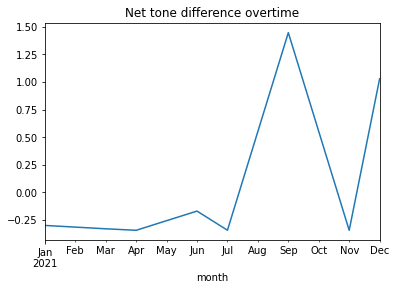

In [48]:
base_overtime['net_tone_diff'].plot(title='Net tone difference overtime')

# Saving Models

In [49]:
"""
#Save Transformer models
save_path = os.path.join(current_directory,"Model")
if not os.path.exists(save_path):
    os.mkdir(save_path)

    
transformer_model.save_pretrained(os.path.join(save_path,"transformer_model"))
#Save LDA,vectorizer,topic_dictionary
transformer_tokenizer.save_pretrained(os.path.join(save_path,"transformer_tokenizer"))
#save tokenizer settings
pickle.dump(tokenizer_settings,open(os.path.join(save_path,"tokenizer_settings.pkl"),"wb"))

#save lda model

with open(os.path.join(save_path,"lda_models.pkl"),'wb') as models:
    pickle.dump((lda_model,vectorizer,topic_dict),models)

"""


'\n#Save Transformer models\nsave_path = os.path.join(current_directory,"Model")\nif not os.path.exists(save_path):\n    os.mkdir(save_path)\n\n    \ntransformer_model.save_pretrained(os.path.join(save_path,"transformer_model"))\n#Save LDA,vectorizer,topic_dictionary\ntransformer_tokenizer.save_pretrained(os.path.join(save_path,"transformer_tokenizer"))\n#save tokenizer settings\npickle.dump(tokenizer_settings,open(os.path.join(save_path,"tokenizer_settings.pkl"),"wb"))\n\n#save lda model\n\nwith open(os.path.join(save_path,"lda_models.pkl"),\'wb\') as models:\n    pickle.dump((lda_model,vectorizer,topic_dict),models)\n\n'